In [2]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.87  Python-3.11.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 4GB Laptop GPU, 4096MiB)
Setup complete  (16 CPUs, 15.7 GB RAM, 59.7/62.5 GB disk)


In [3]:
import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.22.0


In [4]:
import numpy as np
print("numpy.__version__:", np.__version__)

numpy.__version__: 1.26.3


In [5]:
import cv2
print("cv2.__version__:", cv2.__version__)

cv2.__version__: 4.10.0


In [6]:
SOURCE_VIDEO_PATH = r"..\videos\vehicle-counting-low.mp4"
MODEL = r"..\models\yolov10m.pt"

In [7]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()
model.to("cuda")
model.device

YOLOv10m summary (fused): 369 layers, 16,543,024 parameters, 0 gradients, 63.9 GFLOPs


device(type='cuda', index=0)

In [8]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

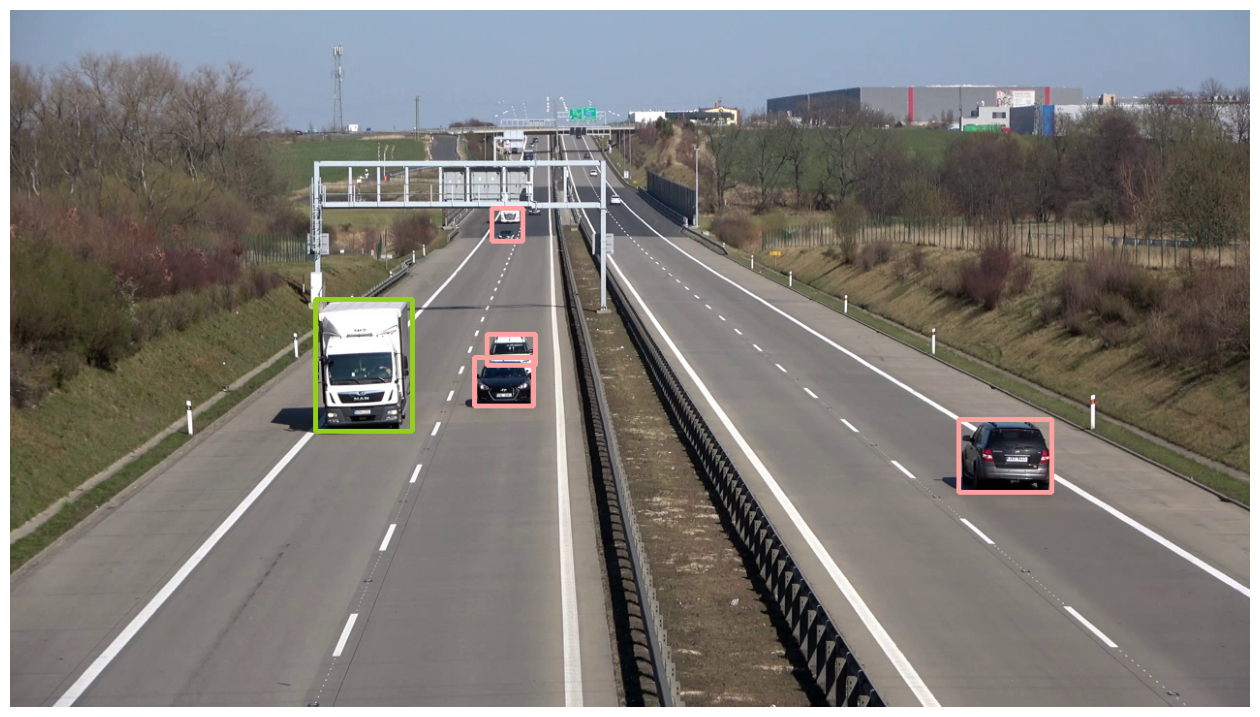

In [9]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

In [10]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"vehicle-counting-result-with-counter.mp4"

In [11]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=30, total_frames=646)

In [12]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections
        )

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    cv_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

    # show annotated frame
    cv2.imshow("frame", cv_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        return None
    

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.


: 